In [2]:
# condition_stability.py
"""Volume 1: Conditioning and Stability.
Nathan Schill
Section 2
Tues. Feb. 14, 2023
"""

import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from scipy import linalg as spla

In [4]:
# Problem 1
def matrix_cond(A):
    """Calculate the condition number of A with respect to the 2-norm."""
    
    # Get singular values
    sv = spla.svdvals(A)

    # If zero is a singular value, return inf
    # if 0 in sv:
    #     return np.inf
    
    return sv[0]/sv[-1]

A = np.random.rand(2,2)
Q, R = np.linalg.qr(A)
C = np.array([[1,0],[0,0]])
D = np.random.rand(3,2)

E = np.random.random((5,5))
E[2] = E[0].copy() # Singular matrix

np.linalg.cond(A), matrix_cond(A), np.linalg.cond(Q), matrix_cond(Q), np.linalg.cond(C), matrix_cond(C),\
np.linalg.cond(D), matrix_cond(D), np.linalg.cond(E), matrix_cond(E)

C:\Users\BYU Rental\AppData\Local\Temp\ipykernel_13048\693773291.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return sv[0]/sv[-1]


(2.3458130479986212,
 2.3458130479986212,
 1.0,
 1.0,
 inf,
 inf,
 9.991320772634054,
 9.991320772634054,
 2.0932364039655028e+16,
 2.0932364039655028e+16)

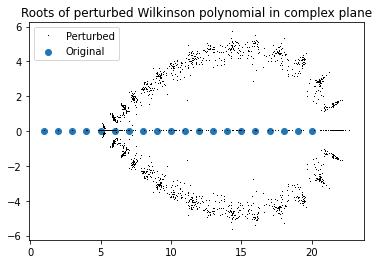

(0.9547747336800263, 6.58974052128269e+17)

In [19]:
# TODO: How to calc condition numbers? r instead of difference... which norm...

# Problem 2
def prob2():
    """Randomly perturb the coefficients of the Wilkinson polynomial by
    replacing each coefficient c_i with c_i*r_i, where r_i is drawn from a
    normal distribution centered at 1 with standard deviation 1e-10.
    Plot the roots of 100 such experiments in a single figure, along with the
    roots of the unperturbed polynomial w(x).

    Returns:
        (float) The average absolute condition number.
        (float) The average relative condition number.
    """
    PERTURB_VAR = 1e-10
    
    w_roots = np.arange(1, 21)

    # Get the exact Wilkinson polynomial coefficients using SymPy.
    x, i = sy.symbols('x i')
    w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
    w_coeffs = np.array(w.all_coeffs())
    
    # Store absolute and relative condition numbers
    abs_cond = [None] * 100
    rel_cond = [None] * 100

    for i in range(100):
        # Get perturbed coefficients
        r = np.random.normal(1, PERTURB_VAR, size=len(w_coeffs))
        new_coeffs = w_coeffs * r
        
        # Get roots, then get real and imaginary parts
        new_roots = np.roots(np.poly1d(new_coeffs))
        r, c = np.real(new_roots), np.imag(new_roots)
        
        if i == 0:
            plt.plot(r, c, color='k', marker=',', lw=0, label='Perturbed')
        else:
            plt.plot(r, c, color='k', marker=',', lw=0)

        # Estimate the absolute condition number in the infinity norm
        abs_cond[i] = spla.norm(new_roots - w_roots, np.inf) / spla.norm(r, np.inf)

        # Estimate the relative condition number in the infinity norm
        rel_cond[i] = abs_cond[i] * spla.norm(w_coeffs, np.inf) / spla.norm(w_roots, np.inf)

    # Plot properties
    plt.scatter(w_roots, np.zeros(len(w_roots)), label='Original')
    plt.legend()
    plt.title('Roots of perturbed Wilkinson polynomial in complex plane')
    plt.show()

    # Return means
    return np.mean(abs_cond), np.mean(rel_cond)

prob2()

In [4]:
# Helper function
def reorder_eigvals(orig_eigvals, pert_eigvals):
    """Reorder the perturbed eigenvalues to be as close to the original eigenvalues as possible.
    
    Parameters:
        orig_eigvals ((n,) ndarray) - The eigenvalues of the unperturbed matrix A
        pert_eigvals ((n,) ndarray) - The eigenvalues of the perturbed matrix A+H
        
    Returns:
        ((n,) ndarray) - the reordered eigenvalues of the perturbed matrix
    """
    n = len(pert_eigvals)
    sort_order = np.zeros(n).astype(int)
    dists = np.abs(orig_eigvals - pert_eigvals.reshape(-1,1))
    for _ in range(n):
        index = np.unravel_index(np.argmin(dists), dists.shape)
        sort_order[index[0]] = index[1]
        dists[index[0],:] = np.inf
        dists[:,index[1]] = np.inf
    return pert_eigvals[sort_order]

In [24]:
# TODO: Compare results

# Problem 3
def eig_cond(A):
    """Approximate the condition numbers of the eigenvalue problem at A.

    Parameters:
        A ((n,n) ndarray): A square matrix.

    Returns:
        (float) The absolute condition number of the eigenvalue problem at A.
        (float) The relative condition number of the eigenvalue problem at A.
    """
    PERTURB_VAR = 1e-10

    # Compute H, A tilde
    H = np.random.normal(0, PERTURB_VAR, size=A.shape) + 1j*np.random.normal(0, PERTURB_VAR, size=A.shape)
    At = A + H

    # Get eigenvalues (sort perturbed matrix's eigenvalues)
    A_eig = spla.eigvals(A)
    At_eig = reorder_eigvals(A_eig, spla.eigvals(At))

    # Approximate absolute and relative condition numbers with 2-norms
    abs_cond = spla.norm(A_eig - At_eig)/spla.norm(H, ord=2)
    rel_cond = spla.norm(A, ord=2)/spla.norm(A_eig) * abs_cond

    return abs_cond, rel_cond

A = np.random.rand(2,2)
Q, R = np.linalg.qr(A)
C = np.array([[1,0],[0,0]])
D = np.array([[10, 0],[42, 3]])

eig_cond(A), eig_cond(Q), eig_cond(C), eig_cond(D)

((0.8284832070943843, 0.7683719000231765),
 (0.8395336656629577, 0.5936399480246773),
 (0.5535075829745315, 0.5535075829745315),
 (5.329335493863545, 22.088843118791267))

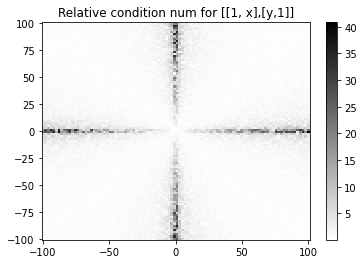

In [47]:
# Problem 4
def prob4(domain=[-100, 100, -100, 100], res=50):
    """Create a grid [x_min, x_max] x [y_min, y_max] with the given resolution. For each
    entry (x,y) in the grid, find the relative condition number of the
    eigenvalue problem, using the matrix   [[1, x], [y, 1]]  as the input.
    Use plt.pcolormesh() to plot the condition number over the entire grid.

    Parameters:
        domain ([x_min, x_max, y_min, y_max]):
        res (int): number of points along each edge of the grid.
    """
    # Get points
    x = np.linspace(domain[0], domain[1], res)
    y = np.linspace(domain[2], domain[3], res)
    X, Y = np.meshgrid(x, y)

    # Get relative condition number for each matrix in grid
    A = [[eig_cond(np.array([[1,u],[v,1]]))[1] for u in x] for v in y]
    
    # Plot
    plt.pcolormesh(X, Y, A, cmap='gray_r')
    plt.colorbar()
    plt.title('Approximate relative condition num for [[1, x],[y,1]]')
    plt.show()

prob4(res=100)

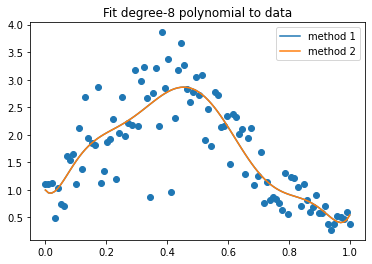

(4.6998500879570075, 4.699850087870958)

In [85]:
# Problem 5
def prob5(n):
    """Approximate the data from "stability_data.npy" on the interval [0,1]
    with a least squares polynomial of degree n. Solve the least squares
    problem using the normal equation and the QR decomposition, then compare
    the two solutions by plotting them together with the data. Return
    the mean squared error of both solutions, ||Ax-b||_2.

    Parameters:
        n (int): The degree of the polynomial to be used in the approximation.

    Returns:
        (float): The forward error using the normal equations.
        (float): The forward error using the QR decomposition.
    """
    
    # Load data
    xk, yk = np.load('stability_data.npy').T
    A = np.vander(xk, n+1)

    # Method 1: x = (A.T A)^-1 A.T b
    x1 = spla.inv(A.T@A) @ A.T @ yk

    # Method 2: A.T A x = A.T b with QR decomp
    Q, R = spla.qr(A.T@A, mode='economic')
    x2 = spla.solve_triangular(R, Q.T@A.T@yk)

    # Get polynomials (note reversal of coefficients)
    poly1 = np.polynomial.polynomial.Polynomial(x1[::-1])
    poly2 = np.polynomial.polynomial.Polynomial(x2[::-1])

    # Plot domain
    domain = np.linspace(min(xk), max(xk), 100)
    
    # Plot
    plt.plot(domain, poly1(domain), label='method 1')
    plt.plot(domain, poly2(domain), label='method 2')

    # Plot properties
    plt.scatter(xk, yk)
    plt.legend()
    plt.title(f'Fit degree-{n} polynomial to data')
    plt.show()

    # Return forward error for each method
    return spla.norm(A@x1 - yk, ord=2), spla.norm(A@x2 - yk, ord=2)

prob5(8)

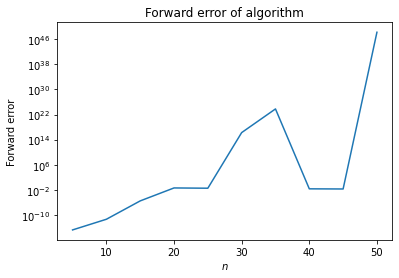

In [107]:
# Problem 6
def prob6():
    """For n = 5, 10, ..., 50, compute the integral I(n) using SymPy (the
    true values) and the subfactorial formula (may or may not be correct).
    Plot the relative forward error of the subfactorial formula for each
    value of n. Use a log scale for the y-axis.
    """
    # Get n
    N = range(5, 51, 5)

    # Get expr
    x, n = sy.symbols('x n')
    expr = x**n * sy.exp(x-1)

    # Get exact and approximate value for each n
    sympy = np.array([sy.N(sy.integrate(expr.subs(n, i), (x,0,1))) for i in N])
    aprox = np.array([(-1)**i * (sy.subfactorial(i) - sy.factorial(i)/np.e) for i in N])

    # Get forward error
    error = np.abs(sympy - aprox)
    
    # Plot
    plt.plot(N, error)

    # Plot properties
    plt.xlabel('$n$')
    plt.yscale('log')
    plt.ylabel('Forward error')
    plt.title('Forward error of algorithm')
    plt.show()
    
prob6()